In [200]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk

import spacy 
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from wordcloud import WordCloud
from collections import Counter
from nltk import word_tokenize, FreqDist
import re
import string

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import GRU, Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping



Using TensorFlow backend.


In [5]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time

In [6]:
import glob

# Kickstarter NLP Project Introduction

# **Project Objectives**
1. Use NLP to build a model that can predict whether or not a kickstarter campaign will be successful, based solely on that projects description blurb. 
2. Identify a top list of words and phrases that appear in successful kickstarter projects. 
3. Besides blurbs, identify which attributes of a kickstart project have the largest effect on success.

In [7]:
#First bringing in all the data and putting it in one dataset
df = pd.concat([pd.read_csv(f) for f in glob.glob('data/Kickstarter*.csv')], ignore_index = True)

In [8]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,0,"An intelligent, heavy terrain construction robot.","{""id"":338,""name"":""Robots"",""slug"":""technology/r...",0,SE,1467285495,"{""id"":2051859794,""name"":""Nikola Andrasic"",""slu...",SEK,kr,True,...,omni-intelligent-construction-robots,https://www.kickstarter.com/discover/categorie...,False,False,canceled,1468562993,0.118480,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,domestic
1,5,Twelve months of gorgeous local Brisbane model...,"{""id"":325,""name"":""Calendars"",""slug"":""publishin...",154,AU,1399379096,"{""id"":429445942,""name"":""Sarah and Ryan"",""slug""...",AUD,$,True,...,dr-rys-diamonds,https://www.kickstarter.com/discover/categorie...,False,False,failed,1402392877,0.936146,"{""web"":{""project"":""https://www.kickstarter.com...",154.464154,domestic
2,1,This is a short film about married Marines who...,"{""id"":293,""name"":""Drama"",""slug"":""film & video/...",1,US,1528203193,"{""id"":1911329541,""name"":""Gary Winstead"",""is_re...",USD,$,True,...,the-lady-in-red,https://www.kickstarter.com/discover/categorie...,False,False,failed,1530903638,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,domestic
3,111,"A photo book tracing the sites of Spain's 114,...","{""id"":280,""name"":""Photobooks"",""slug"":""photogra...",11812,NL,1510400357,"{""id"":629822067,""name"":""Miquel Gonzalez"",""slug...",EUR,€,False,...,memoria-perdida-recovering-spains-lost-memory-...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1521457200,1.237765,"{""web"":{""project"":""https://www.kickstarter.com...",11914.723002,international
4,53,"""The Root of Perfection"" is a science-fiction ...","{""id"":301,""name"":""Science Fiction"",""slug"":""fil...",3663,US,1528341672,"{""id"":2054701261,""name"":""Cole Daniel Hills"",""i...",USD,$,True,...,the-root-of-perfection,https://www.kickstarter.com/discover/categorie...,True,False,successful,1532586601,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3663.500000,domestic


In [9]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

In [10]:
df['state'].value_counts()

successful    118425
failed         75254
canceled        8604
live            7175
suspended        630
Name: state, dtype: int64

For the purposes of this project, we are only interested in successful and failed projects- as a result I will drop any project which has any of the the three following states...

- canceled
- live
- suspended


In [11]:
#Dropping any state that is not successful or failed.
df = df.drop(df[(df['state'] == 'live') | (df['state'] == 'canceled') | (df['state'] == 'suspended')].index)

In [12]:
df['state'].value_counts()

successful    118425
failed         75254
Name: state, dtype: int64

In [13]:
len(df)

193679

We're still left with nearly 200,000 projects.

# Preprocessing and Exploring the Data

For the first part of this project, NLP classification, I'm only interested in the blurbs and the project labels. I'll create a new dataframe with just those columns.

In [14]:
blurb_df = df[['blurb', 'state']]

In [15]:
blurb_df.head()

,blurb,state
1,Twelve months of gorgeous local Brisbane model...,failed
2,This is a short film about married Marines who...,failed
3,"A photo book tracing the sites of Spain's 114,...",successful
4,"""The Root of Perfection"" is a science-fiction ...",successful
5,Never miss a moment with Cleep: the 13mp Camer...,successful


In [16]:
# Applying a binary label to the state of the project and putting it in a new column
le = LabelEncoder()
blurb_df['failed_or_success'] = le.fit_transform(df['state'])

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Checking for NA values and removing them...

In [17]:
print(blurb_df['blurb'].isna().sum())

2


In [18]:
blurb_df.dropna(inplace=True)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
blurb_df['blurb'].isna().sum()

0

Great, so I've removed all null values but I still need to check for duplicates...

In [20]:
blurb_df['blurb'].describe()

count                                                193677
unique                                               168734
top       Help support the largest creative collaboratio...
freq                                                     52
Name: blurb, dtype: object

Based on the description above, it appears that there are only around 168k unique records, and about 25k of our 193k projects are repeated somewhere in the data. Below I removed these duplicates.

In [21]:
# Dropping the duplicate blurbs for this project.
blurb_df.drop_duplicates(subset='blurb', inplace=True)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
blurb_df['blurb'].describe()

count                                                168734
unique                                               168734
top       We need your help to get the new album ready, ...
freq                                                      1
Name: blurb, dtype: object

Text(0.5, 1.0, 'Failed vs. Successful Kickstarter Projects')

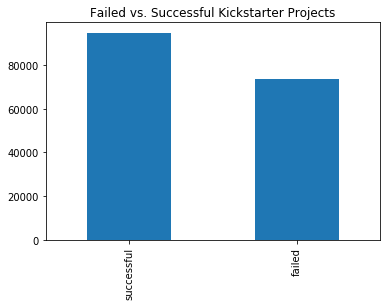

In [23]:
# A quick bar plot of the states of our sample after removing duplicates and nulls
blurb_df['state'].value_counts().plot(kind='bar')
plt.title("Failed vs. Successful Kickstarter Projects")

## Visualizing Blurbs in Word Clouds

In [24]:
#First, I need to take out any punctuation and stop words that will muddy up the wordclouds
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
#Defining stop words to remove
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [26]:
# Building a clean_text function that will lowercase, remove punctuation, and return the cleaned text
def clean_text(text):
    #Replaces all punctuation with spaces and lowercases all words
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    #Removes stopwords
    return ' '.join([word for word in text.split() if word not in (stop)])

In [27]:
blurb_df['cleaned_text'] = list(map(lambda t: clean_text(t), blurb_df['blurb']))

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
#Checking for null blurbs
blurb_df['blurb'].isna().sum()

0

In [29]:
blurb_df.head()

,blurb,state,failed_or_success,cleaned_text
1,Twelve months of gorgeous local Brisbane model...,failed,0,twelve months gorgeous local brisbane models c...
2,This is a short film about married Marines who...,failed,0,short film married marines picked older couple...
3,"A photo book tracing the sites of Spain's 114,...",successful,1,photo book tracing sites spain 114 000 disappe...
4,"""The Root of Perfection"" is a science-fiction ...",successful,1,root perfection science fiction dramedy want n...
5,Never miss a moment with Cleep: the 13mp Camer...,successful,1,never miss moment cleep 13mp camera wear wrist


In [30]:
text = " ".join(blurb for blurb in blurb_df['cleaned_text'])

In [31]:
wordcloud = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text)

Text(0.5, 1.0, 'Wordcloud for ALL Kickstarter Projects')

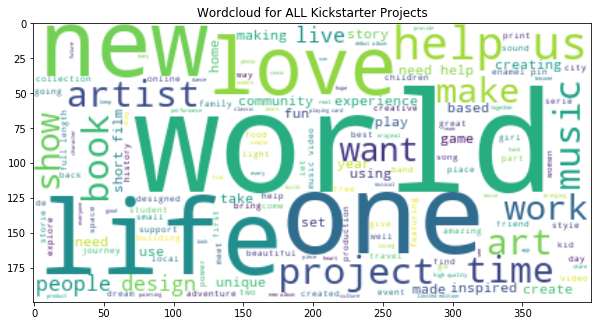

In [32]:
#Trying first wordcloud- this is for ALL projects- successful and non-successful
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud for ALL Kickstarter Projects')

In [33]:
#Wordcloud for just successful projects
text_success = " ".join(blurb for blurb in blurb_df.loc[blurb_df['failed_or_success'] == 1, 'cleaned_text'])
wordcloud_success = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_success)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


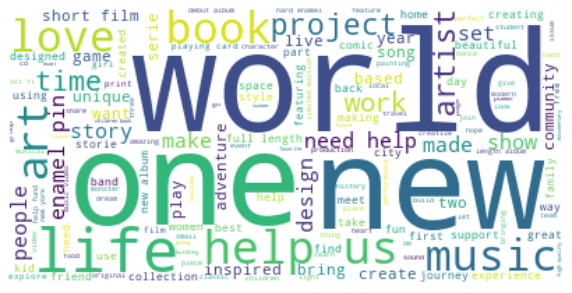

In [34]:
#Visualization of success wordcloud
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud_success, interpolation='bilinear')
#plt.title('Wordcloud for Successful Kickstarter Projects')
plt.axis('off')
fig.show()

In [35]:
#Wordcloud for just failed projects
text_failure = " ".join(blurb for blurb in blurb_df.loc[blurb_df['failed_or_success'] == 0, 'cleaned_text'])
wordcloud_failure = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_failure)

(-0.5, 399.5, 199.5, -0.5)

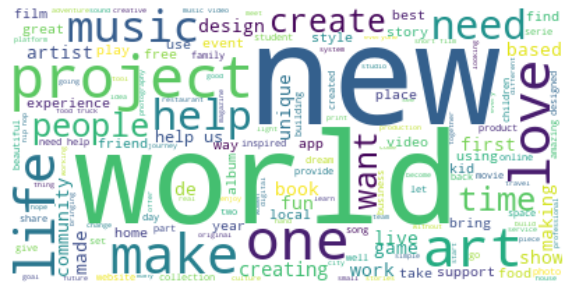

In [36]:
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud_failure, interpolation='bilinear')
#plt.title('Wordcloud for Failed Kickstarter Projects')
plt.axis('off')

## Creating top 10 word lists for successful and failed projects

In [37]:
def process_blurb(blurb):
    tokens = nltk.word_tokenize(blurb)
    list_of_tokens = [token.lower() for token in tokens]
    return list_of_tokens

In [38]:
# Creating list of tokens for failed projects
failure_processed_data = list(map(process_blurb, blurb_df.loc[blurb_df['failed_or_success'] == 0, 'cleaned_text']))

# Creating list of tokens for successful projects
success_processed_data = list(map(process_blurb, blurb_df.loc[blurb_df['failed_or_success'] == 1, 'cleaned_text']))

In [39]:
#Creating list so I can use FreqDist on each set
failed_blurbs_concat = []
for blurb in failure_processed_data:
    failed_blurbs_concat += blurb
    
success_blurbs_concat = []
for blurb in success_processed_data:
    success_blurbs_concat += blurb

In [40]:
failed_blurbs_freqdist = FreqDist(failed_blurbs_concat)
failed_blurbs_freqdist.most_common(20)

[('help', 7004),
 ('new', 5586),
 ('world', 4314),
 ('music', 4250),
 ('make', 3985),
 ('art', 3827),
 ('want', 3727),
 ('create', 3368),
 ('people', 3198),
 ('one', 3181),
 ('life', 3080),
 ('need', 2994),
 ('first', 2953),
 ('project', 2943),
 ('film', 2713),
 ('book', 2684),
 ('love', 2651),
 ('get', 2604),
 ('food', 2577),
 ('game', 2508)]

In [41]:
success_blurbs_freqdist = FreqDist(success_blurbs_concat)
success_blurbs_freqdist.most_common(20)

[('help', 10813),
 ('new', 10473),
 ('album', 6759),
 ('book', 6584),
 ('first', 5869),
 ('world', 5519),
 ('music', 5146),
 ('art', 5118),
 ('film', 4527),
 ('us', 4288),
 ('one', 4088),
 ('life', 4049),
 ('make', 4034),
 ('need', 3456),
 ('story', 3437),
 ('love', 3380),
 ('get', 3347),
 ('project', 3239),
 ('series', 3217),
 ('time', 2888)]

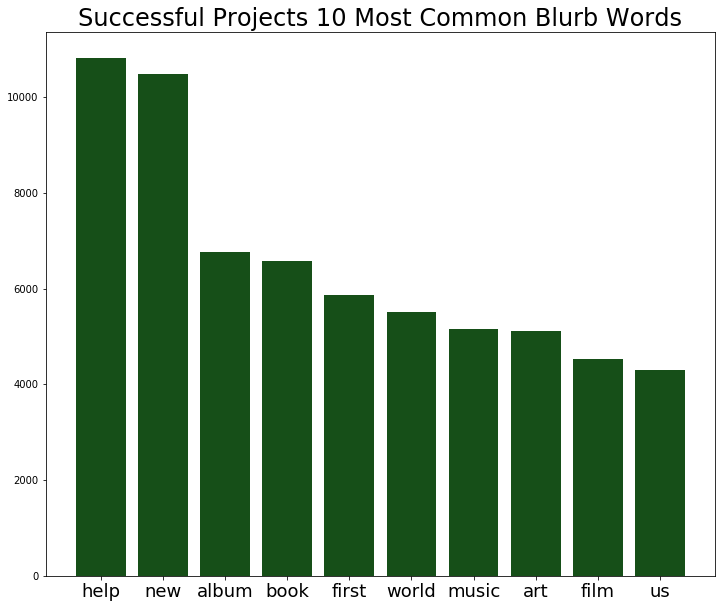

In [42]:
#Success word count visualization

success_word_list = []
success_count_list= [] 
for word, count in success_blurbs_freqdist.most_common(10):
    success_word_list.append(word)
    success_count_list.append(count)
    
plt.figure(figsize = (12,10))
success_count_df = pd.DataFrame({'Word': success_word_list, 'Count':success_count_list})
plt.bar(success_count_df['Word'], success_count_df['Count'], color='#164f18')
plt.title('Successful Projects 10 Most Common Blurb Words', fontsize=24)
plt.xticks(fontsize=18)
plt.show()


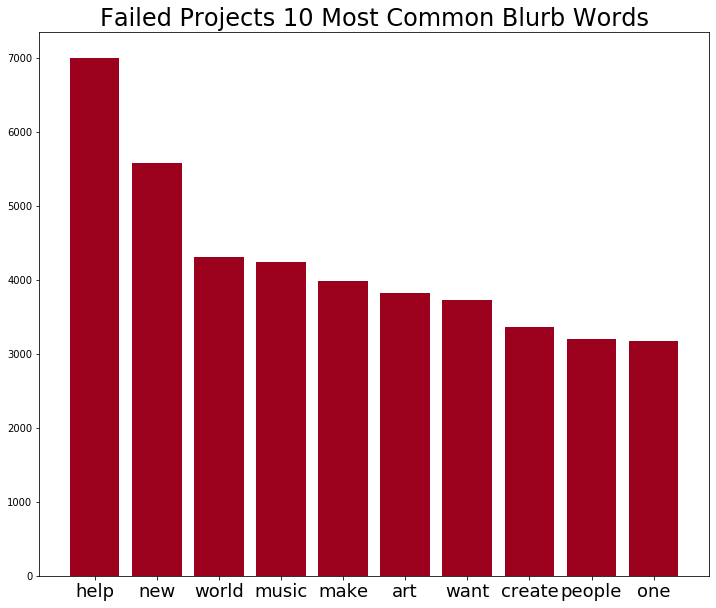

In [43]:
#Failure word count visualization

failure_word_list = []
failure_count_list= [] 
for word, count in failed_blurbs_freqdist.most_common(10):
    failure_word_list.append(word)
    failure_count_list.append(count)
    
plt.figure(figsize = (12,10))
failure_count_df = pd.DataFrame({'Word': failure_word_list, 'Count':failure_count_list})
plt.bar(failure_count_df['Word'], failure_count_df['Count'], color='#9b001c')
plt.title('Failed Projects 10 Most Common Blurb Words', fontsize=24)
plt.xticks(fontsize=18)
plt.show()

## Examples of top-performing blurbs

There wasn't a major difference in the word composition of successful projects vs. failed projects. In order to get a sense of what sort of blurbs were bringing in the most support, I sorted by number of backers and printed out the top 10 blurbs of all time.

In [44]:
#Creating a df sorted by backer count
sorted_df = df.sort_values(by=['backers_count'], ascending=False)

In [45]:
top_10_blurbs = list(sorted_df['blurb'][0:10])

In [46]:
for blurb in top_10_blurbs:
    print(blurb)
    print('\n')

Bring Reading Rainbow’s library of interactive books & video field trips to more platforms & provide free access to classrooms in need!


UPDATED: This is it. We're making a Veronica Mars movie! Now the only question is: how big can we make it? We need your help!


The creative talent behind Banjo-Kazooie and Donkey Kong Country reveal an all-new platforming adventure for consoles and PC!


Yu Suzuki presents the long awaited third installment in the Shenmue series.


Classic Japanese side-scrolling action, evolved and transformed by Keiji Inafune, an all-star team of veteran Mega Man devs...and YOU!


IGAVANIA (n): A gothic, exploration-focused action platformer, designed by one of the godfathers of the genre!


Cracking open the last closed platform: the TV.  A beautiful, affordable console -- built on Android, by the creator of Jambox.


The world's first dodgeball card game. Collect cards. Play your hand. Throw things at your friends.


The world's first dodgeball card game. Collec

## Visualizing blurb length vs. project success

In [47]:
#Creating new blurb length feature which will contain the length of each blurb in words
df['blurb_length'] = df['blurb'].str.split().str.len()

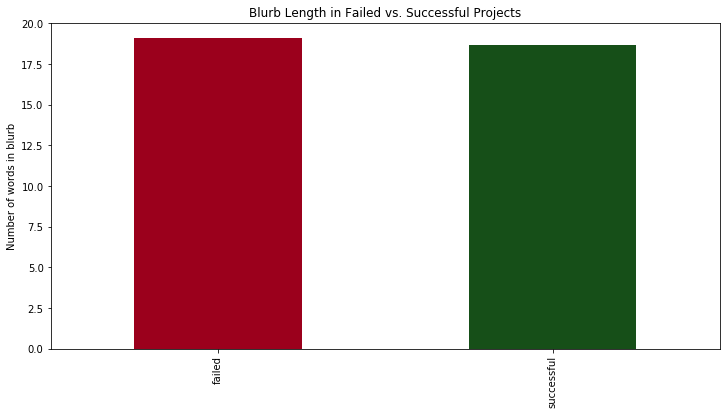

In [48]:
plt.figure(figsize=(12,6))
df.groupby('state')['blurb_length'].mean().plot(kind='bar', color=['#9b001c', '#164f18'])
plt.xlabel('')
plt.ylabel('Number of words in blurb')
plt.title('Blurb Length in Failed vs. Successful Projects')
plt.show()


**Still difficult to determine any trends! Hopefully my deep-learning models can do a better job of finding patterns than I can!**

# Turning words into processable data through embedding

With the blurbs in their current format, they will be impossible for a machine learning/deep learning algoritm to classify because these algorithms are not built to process strings. As such, I must convert these strings into numerical representations in order to utilize machine learning and classification techniques on these blurbs. There are two ways to approach this, and ultimately I decided on embedding but I will discuss both methods below.

1. Preprocess the data by (done above)...
    - Removing stop words
    - Taking out punctuation
    - Lowercasing everything
    
    
2. Vectorize the data

    - **Method 1**: Count Vectorization- bag of words with one hot encoded vectors for each word. This strategy essentially creates a column for each word in the corpus and then one hot encodes each blurb according to whether or not the blurb had each word. So for example, a blurb with 25 words would have 25 columns with 1s and the rest of the columns (thousands) with 0s. The issue with this strategy is that it creates massive "spare vectors," where some vectors will have 99.9%+ of their content be 0s. This is not a computationlly efficient, and for this reason I will use embedding instead of the bag of words strategy.
    
    - **Method 2**: Word Embedding- Dense representation of words and semantic meanings. This strategy creates word vectors similar to count vectorization above, but focuses on capturing the semantic meaning between words and reducing the dimensionality of the data. I opt to use word embedding because of the dimensionality and the ease of implementation for deep learning models.
    
In order to change my text to vectors, I used keras to tokenize each blurb, convert it to a sequence, and then pad that sequence so all sequences are the same length.

In [132]:
# Establishing features and labels as X and y
X = blurb_df['cleaned_text']
y = blurb_df['failed_or_success']

In [133]:
#Instantiates a tokenizer object and sets it so the model only keeps the 20000 most used words
tokenizer = Tokenizer(num_words = 20000)
#Applies the tokenizer to our newly crated X feature dataframe
tokenizer.fit_on_texts(list(X))
#Converting our data to sequences
X = tokenizer.texts_to_sequences(X)
#Padding the sequences to equalize length
X = sequence.pad_sequences(X, maxlen=200)

In [134]:
X.shape

(168734, 200)

In [135]:
# Put this in to make sure keras reads target as binary categorical (failed or success)
from keras.utils import to_categorical
y_binary_cat = to_categorical(y)
y_binary_cat[2]

array([0., 1.], dtype=float32)

In [136]:
#Train and test with test size at 10%
X_train, X_test, y_train, y_test = train_test_split(X, y_binary_cat, test_size=0.1, random_state=42) 

In [137]:
X_train.shape

(151860, 200)

In [138]:
X_test.shape

(16874, 200)

# Modeling: Building a recurrent neural network(RNN)

I decided to use deep learning neural network models due to their ability to efficiently and accurately solve text classification problems.

Below, I build out the first iteration of my recurrent neural network. This section will consist of me trying different neural networks with different layers and parameters to optimize testing accuracy. The models can be broadly divided into two kinds of models:

1. Models using their own embedding layer for embedding words into vectors
2. Models using pre-trained algorithms to form vectors

**After I run through several iterations of these models with different parameters and layers, I will pick the best performing layer structures and parameters to create an optimal model. See section 3.1 below for more detail**

Before doing anything else, I'll need to set some parameters to build the  deep learning models with. 

In [114]:
# number of unique words to consider in the corpus
max_features = 20000 

# max number of words in a blurb (same as sequence length)
max_len = 200 

# dimension of the embedding variable 
embedding_dims = 128

## Helper functions for modeling

In [119]:
# Setting up a function to help visualize performance of deep learning models.

def deep_learning_visuals(model_history):

    #Store the fitted model history into a dictionary
    hist_dict = model_history.history
    
    # Putting the training and testing loss into the dictionary
    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']

    # Putting the training and testing accuracies into the dictionary
    acc_values = hist_dict['acc']
    val_acc_values = hist_dict['val_acc'] 
    
    # Getting a range of epochs to use as the x-axis (essentially models over time)
    epochs = range(1, len(loss_values) + 1)
    #Create the figure
    fig, ax = plt.subplots(1, 2, figsize=[20,8])
    
    # Formatting plot for losses
    ax[0].plot(epochs, loss_values, 'red', label='Training Loss')
    ax[0].plot(epochs, val_loss_values, 'green', label='Validation Loss')
    ax[0].set_title('Training vs. Validation LOSS', fontsize=25)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].legend()
    
    # Formatting plot for accuracies
    ax[1].plot(epochs, acc_values, 'red', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_values, 'green', label='Validation Accuracy')
    ax[1].set_title('Training vs. Validation ACCURACY', fontsize=25)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)
    
    plt.legend()
    plt.show()

In [229]:
# Shows confusion matrix and classification report for a model after it has been fitted
def results_summary(mymodel, model_name, X_test, y_test):
    model_preds = mymodel.predict(X_test)
    model_measures = mymodel.evaluate(X_test, y_test)
    
    accuracy = round(model_measures[1],4)
    loss = round(model_measures[0],4)
    
    class_report = classification_report(y_test.argmax(axis=1), model_preds.argmax(axis=1), target_names=['Failed', 'Success'])
    
    statement = str("MODEL {} \nAccuracy Score: {} \nLoss: {}".format(model_name, accuracy, loss))
    plot_confusion_matrix(y_test, model_preds, normalize=True)
    print(str(statement + "\n\n" + "CLASSIFICATION REPORT \n" + class_report))



In [226]:
#Plots a confusion matrix of a given model

def plot_confusion_matrix(y_test, model_test, normalize=False):
    cm = confusion_matrix(y_test.argmax(axis=1), model_test.argmax(axis=1))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(4)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.figure(figsize=(6,6))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Failed','Succeeded']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

## Models using their own embedding layer

## Model 1.1: Simple LSTM RNN

Below I explain the basics that each layer is accomplishing. This was my first model so I used other educational examples to set some of the parameters. As I move into other models below I will modify these parameters and tune them to my specific problem.

**Layer breakdown**

- Input layer: First layer of the neural network that takes input values (lists of words in this case) and passes them to the next layer
- Embedding layer: Words(already preprocessed through tokenization and sequencing) are projeted into a limited dimension vector space, thereby reducing the model size and eliminating the curse of dimensionality that comes with spare vectors. Its output is a list of coordinates for the words in my limited dimension vector space. Above, I've set it up so the size of the resulting embedding vector is 128, but this can be tuned.
- LSTM layer: Specialized layer which effectively deals with vanishing and exploding gradients. These layers effectively learn which information is important enough to remember and what can be forgotten in sequence models.
- Pooling layer: Downsamples output of prior layer but retains information from that layer
- Dropout layer: A method to reduce overfitting by downsampling and removing nodes from the previous layer. I use two in my initial model but will vary this in future variations.
- Dense layer: Classic "hidden layer", a linear operation is applied to every input and given a weight and an activation.
- Output layer: Last layer of the network puts the data into desired classes using an activation function- in this case softmax.

**Note** : Going forward I will only summarize the changes from the previous model

In [115]:
# Trying LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(2, activation='softmax'))

In [116]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [117]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 50)           35800     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 102       
Total para

In [118]:
model1_hist = lstm_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.1, verbose=2)

Train on 136674 samples, validate on 15186 samples
Epoch 1/3
 - 316s - loss: 0.6017 - acc: 0.6793 - val_loss: 0.5726 - val_acc: 0.6969
Epoch 2/3
 - 317s - loss: 0.5454 - acc: 0.7273 - val_loss: 0.5759 - val_acc: 0.6977
Epoch 3/3
 - 314s - loss: 0.5012 - acc: 0.7555 - val_loss: 0.5903 - val_acc: 0.6923


## Model 1.1 Results

Not very good, but better than expected! There is clear evidence of overfitting as soon as the 3rd epoch, when validation loss begins to spike. Still- overall **67% testing accuracy** for our first attempt. This is much better than I was anticipating after EDA, because the blurbs from failed and successful projects shared a lot of vocabulary.

16874/16874 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - E

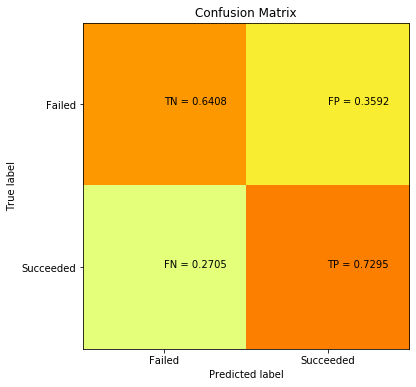

MODEL 1.1 
Accuracy Score: 0.6906 
Loss: 0.5917

CLASSIFICATION REPORT 
              precision    recall  f1-score   support

      Failed       0.65      0.64      0.64      7385
     Success       0.72      0.73      0.73      9489

    accuracy                           0.69     16874
   macro avg       0.69      0.69      0.69     16874
weighted avg       0.69      0.69      0.69     16874



In [230]:
results_summary(lstm_model, "1.1", X_test, y_test)

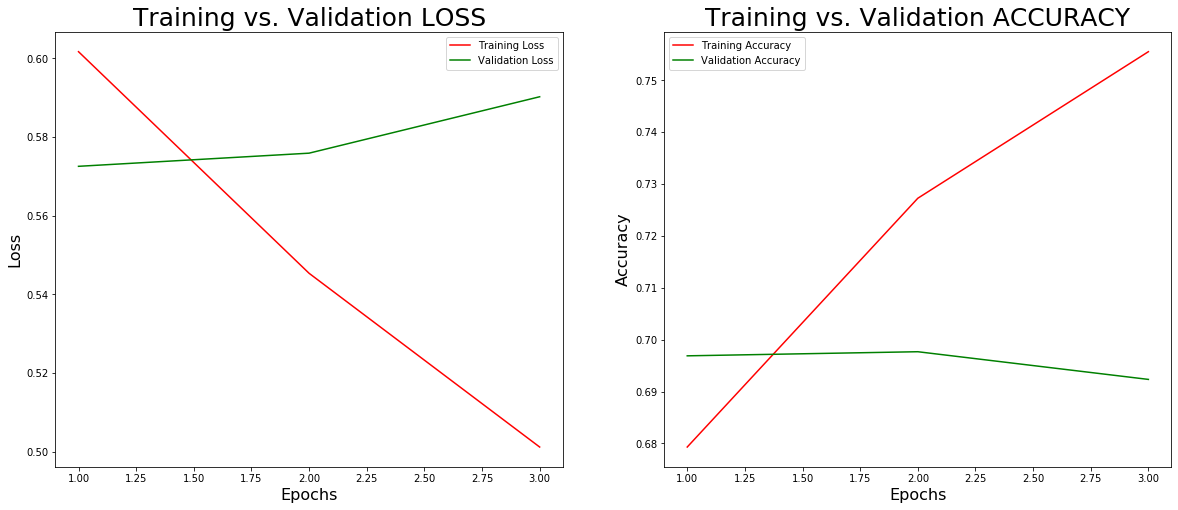

In [141]:
deep_learning_visuals(model1_hist)

# Model 1.2 Bidirectional GRU

**Changes from model 1.1**
- Here, instead of using an LSTM cell I use a GRU cell. There is still ambiguity in the data science community as to which cell is better, and as such I wanted to try a GRU in this iteration. 
- I decided to try a bidirectional sequence model. Typically in an RNN, the sequence of words is read forward to backward and predictions are made one word at a time. This means that the model doesn't know the 4th word of the blurb when it reads the 2nd. It only can make predictions using things which it has already read (in this case, only the 1st word of the blurb). Essentially, the RNN is unable to see the **future** and adjust its predictions using its knowledge of what comes next. A bidirectional RNN solves this problem by having half of the neurons start at the beginning of the data and work to the end, and the other half start at the end of the data and work to the beginning. This is especially applicable for Kickstarter blurbs because the context of all the words together gives each blurb its meaning.

In [64]:
model2 = Sequential()
model2.add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
model2.add(Bidirectional(GRU(30, return_sequences=True)))
model2.add(GlobalMaxPool1D())
model2.add(Dense(70, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(35, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(2, activation='softmax'))

In [65]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 60)           28620     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 70)                4270      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 35)                2485      
_________________________________________________________________
dropout_4 (Dropout)          (None, 35)                0         
__________

In [67]:
model2_hist = model2.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1, verbose=2)

Train on 136674 samples, validate on 15186 samples
Epoch 1/8
 - 313s - loss: 0.5956 - acc: 0.6827 - val_loss: 0.5752 - val_acc: 0.7015
Epoch 2/8
 - 334s - loss: 0.5293 - acc: 0.7356 - val_loss: 0.5787 - val_acc: 0.6974
Epoch 3/8
 - 332s - loss: 0.4512 - acc: 0.7838 - val_loss: 0.6103 - val_acc: 0.6892
Epoch 4/8
 - 316s - loss: 0.3432 - acc: 0.8446 - val_loss: 0.7630 - val_acc: 0.6488
Epoch 5/8
 - 307s - loss: 0.2365 - acc: 0.8985 - val_loss: 0.9654 - val_acc: 0.6520
Epoch 6/8
 - 307s - loss: 0.1555 - acc: 0.9364 - val_loss: 1.3782 - val_acc: 0.6495
Epoch 7/8
 - 305s - loss: 0.1085 - acc: 0.9568 - val_loss: 1.7733 - val_acc: 0.6586
Epoch 8/8
 - 304s - loss: 0.0814 - acc: 0.9691 - val_loss: 1.8767 - val_acc: 0.6569


## Model 1.2 Results

In [231]:
results_summary(model2, "1.2", X_test, y_test)

NameError: name 'model2' is not defined

Overall model 1.2 performed slightly worse than model one from both an accuracy and a loss standpoint. I'm also still seeing similar issues of overfitting.

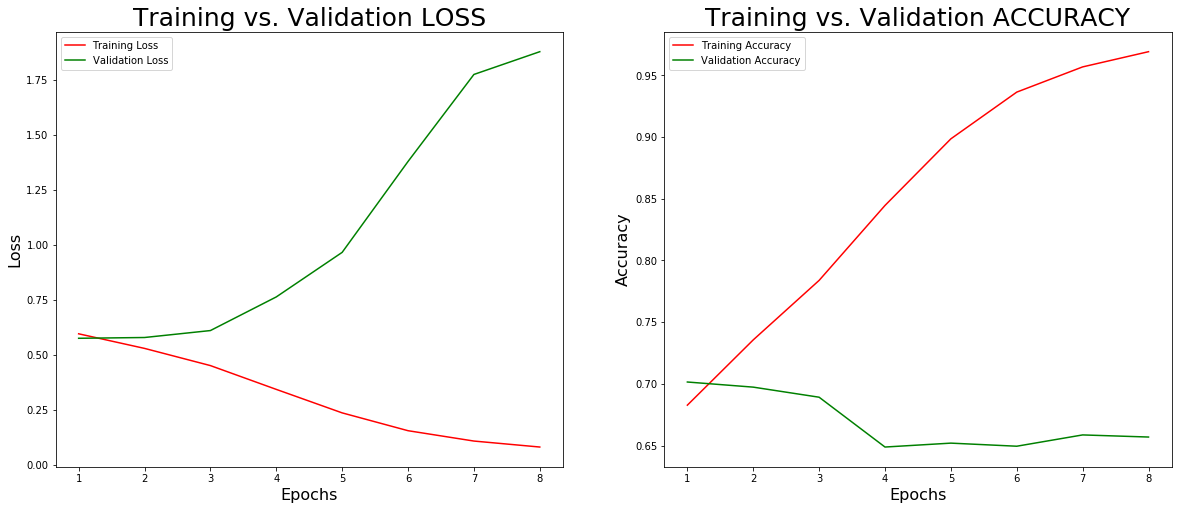

In [70]:
deep_learning_visuals(model2_hist)

Clearly overfitting, let's add some regulariziation to this and see if we can't fix it.

# Model 1.3: Adding Regularization

I'm still optimistic about using bidirectional sequencing for this task, so I'll try adding regularization and changing a few other things....

- Added a lasso regularizer(L1) to hopefully reduce overfitting in the above models. 
- Dropped a dense and a dropout layer to see if having larger layers near the output layer improves accuracy
- Tried sigmoid activation instead of softmax

In [71]:
model3_regularize = Sequential()
model3_regularize.add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
model3_regularize.add(Bidirectional(GRU(30, return_sequences=True)))
model3_regularize.add(GlobalMaxPool1D())
model3_regularize.add(Dense(70, kernel_regularizer=regularizers.l1(0.007), activation='relu'))
model3_regularize.add(Dropout(0.5))
#model3_regularize.add(Dense(35, kernel_regularizer=regularizers.l1(0.007), activation='relu'))
#model3_regularize.add(Dropout(0.3))
model3_regularize.add(Dense(2, activation='sigmoid'))

In [72]:
model3_regularize.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
model3_regularize.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 60)           28620     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 70)                4270      
_________________________________________________________________
dropout_5 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 142       
Total params: 2,593,032
Trainable params: 2,593,032
Non-trainable params: 0
_________________________________________________________________


In [74]:
hist_model3_regularize = model3_regularize.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1, verbose=2)

Train on 136674 samples, validate on 15186 samples
Epoch 1/8
 - 303s - loss: 0.7433 - acc: 0.5621 - val_loss: 0.6644 - val_acc: 0.5697
Epoch 2/8
 - 301s - loss: 0.6290 - acc: 0.6845 - val_loss: 0.6051 - val_acc: 0.6981
Epoch 3/8
 - 301s - loss: 0.5745 - acc: 0.7374 - val_loss: 0.6057 - val_acc: 0.6943
Epoch 4/8
 - 304s - loss: 0.5273 - acc: 0.7705 - val_loss: 0.6429 - val_acc: 0.6899
Epoch 5/8
 - 302s - loss: 0.4786 - acc: 0.8032 - val_loss: 0.6693 - val_acc: 0.6767
Epoch 6/8
 - 303s - loss: 0.4265 - acc: 0.8349 - val_loss: 0.7205 - val_acc: 0.6738
Epoch 7/8
 - 301s - loss: 0.3754 - acc: 0.8657 - val_loss: 0.7947 - val_acc: 0.6582
Epoch 8/8
 - 301s - loss: 0.3292 - acc: 0.8908 - val_loss: 0.8772 - val_acc: 0.6544


## Model 1.3 Results

In [75]:
results_summary(model3_regularize, "1.3", X_test, y_test)

16874/16874 [==============================] - ETA: 11 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  

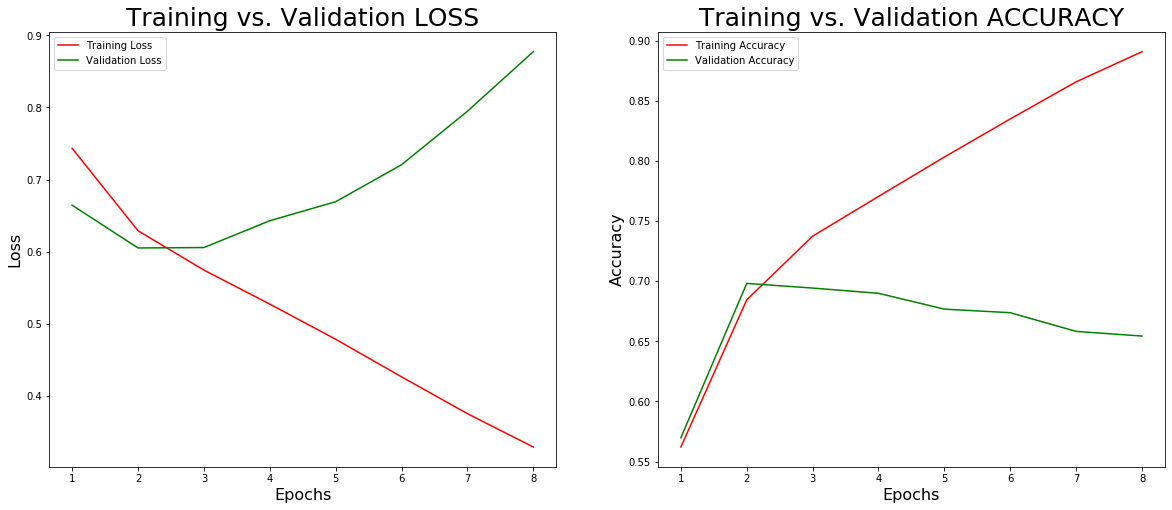

In [77]:
deep_learning_visuals(hist_model3_regularize)

# Model 1.4: Increased Batch size, bidirectional LSTM

- In this iteration I use L2 regularizers instead of L1. 
- Add in a second dropout and hidden layer


In [78]:
model4_regularize = Sequential()
model4_regularize.add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
model4_regularize.add(Bidirectional(LSTM(30, return_sequences=True)))
model4_regularize.add(GlobalMaxPool1D())
model4_regularize.add(Dense(70, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model4_regularize.add(Dropout(0.5))
model4_regularize.add(Dense(35, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model4_regularize.add(Dropout(0.5))
model4_regularize.add(Dense(2, activation='softmax'))

In [79]:
model4_regularize.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
model4_regularize.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 60)           38160     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 60)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 70)                4270      
_________________________________________________________________
dropout_6 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 35)                2485      
_________________________________________________________________
dropout_7 (Dropout)          (None, 35)                0         
__________

In [81]:
hist_model4_regularize = model4_regularize.fit(X_train, y_train, epochs=8, batch_size=60, validation_split=0.1, verbose=2)

Train on 136674 samples, validate on 15186 samples
Epoch 1/8
 - 217s - loss: 0.6586 - acc: 0.6680 - val_loss: 0.5849 - val_acc: 0.6983
Epoch 2/8
 - 216s - loss: 0.5664 - acc: 0.7292 - val_loss: 0.5902 - val_acc: 0.6958
Epoch 3/8
 - 215s - loss: 0.5187 - acc: 0.7623 - val_loss: 0.6012 - val_acc: 0.6965
Epoch 4/8
 - 216s - loss: 0.4673 - acc: 0.7958 - val_loss: 0.6582 - val_acc: 0.6769
Epoch 5/8
 - 220s - loss: 0.4128 - acc: 0.8303 - val_loss: 0.7385 - val_acc: 0.6695
Epoch 6/8
 - 218s - loss: 0.3547 - acc: 0.8645 - val_loss: 0.8450 - val_acc: 0.6546
Epoch 7/8
 - 218s - loss: 0.3014 - acc: 0.8921 - val_loss: 0.9877 - val_acc: 0.6536
Epoch 8/8
 - 218s - loss: 0.2589 - acc: 0.9129 - val_loss: 1.1041 - val_acc: 0.6487


## Model 1.4 Results

In [82]:
results_summary(model4_regularize, "1.4", X_test, y_test)

16874/16874 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - E

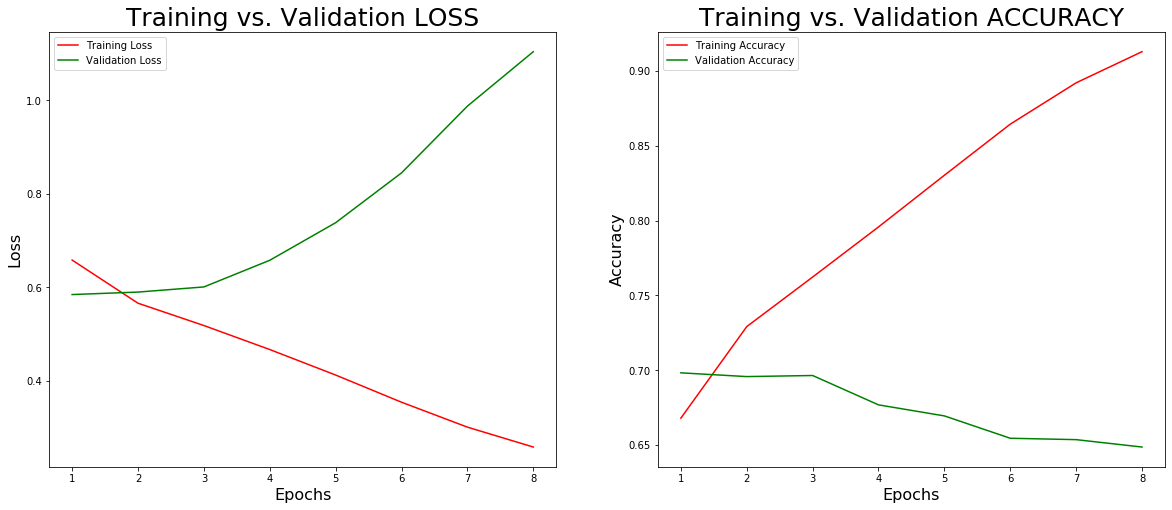

In [84]:
deep_learning_visuals(hist_model4_regularize)

# Model 2.1 RNN with GloVe embedding

In [85]:
# load the glove6B embedding
# This is a set of pre-trained word vectors that contained 840 billion tokens, and 2.2M vocab words.

embeddings_index = dict()
f = open('glove.6B.50d.txt', encoding='utf8')

for line in f:
    # Note: use split(' ') instead of split() if you get an error
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()



In [86]:
#Showing how many words in the embedding index
print(f'There are {len(embeddings_index)} words in this pre-trained embedding')

There are 400000 words in this pre-trained embedding


In [87]:
# Need to create a weight matrix for our pre-trained embedding layer

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 50))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [88]:
glove_model1 = Sequential()

glove_model1.add(Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len,
                          output_dim=embedding_matrix.shape[1], 
                          weights=[embedding_matrix], trainable=False))

glove_model1.add(Bidirectional(LSTM(30, return_sequences=True)))
glove_model1.add(GlobalMaxPool1D())
glove_model1.add(Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))  #Changed from 70 above
glove_model1.add(Dropout(0.5))
#glove_model1.add(Dense(35, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
#glove_model1.add(Dropout(0.5))
glove_model1.add(Dense(2, activation='softmax'))

In [89]:
glove_model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
glove_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 50)           5422850   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 60)           19440     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 60)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 102       
Total params: 5,445,442
Trainable params: 22,592
Non-trainable params: 5,422,850
_____________________________________________________________

In [91]:
glove_model1_hist = glove_model1.fit(X_train, y_train, epochs=8, batch_size=60, validation_split=0.1, verbose=2)

Train on 136674 samples, validate on 15186 samples
Epoch 1/8
 - 132s - loss: 0.6637 - acc: 0.6487 - val_loss: 0.6297 - val_acc: 0.6557
Epoch 2/8
 - 130s - loss: 0.6152 - acc: 0.6728 - val_loss: 0.6083 - val_acc: 0.6750
Epoch 3/8
 - 129s - loss: 0.6051 - acc: 0.6831 - val_loss: 0.6039 - val_acc: 0.6807
Epoch 4/8
 - 129s - loss: 0.5969 - acc: 0.6893 - val_loss: 0.6009 - val_acc: 0.6842
Epoch 5/8
 - 129s - loss: 0.5920 - acc: 0.6948 - val_loss: 0.5956 - val_acc: 0.6885
Epoch 6/8
 - 129s - loss: 0.5909 - acc: 0.6969 - val_loss: 0.5977 - val_acc: 0.6837
Epoch 7/8
 - 129s - loss: 0.5824 - acc: 0.7048 - val_loss: 0.5950 - val_acc: 0.6875
Epoch 8/8
 - 129s - loss: 0.5779 - acc: 0.7080 - val_loss: 0.5952 - val_acc: 0.6858


## Model 2.1 Results

In [93]:
results_summary(model4_regularize, "2.1", X_test, y_test)

Test Result
 Loss:0.593
 Accuracy:0.689


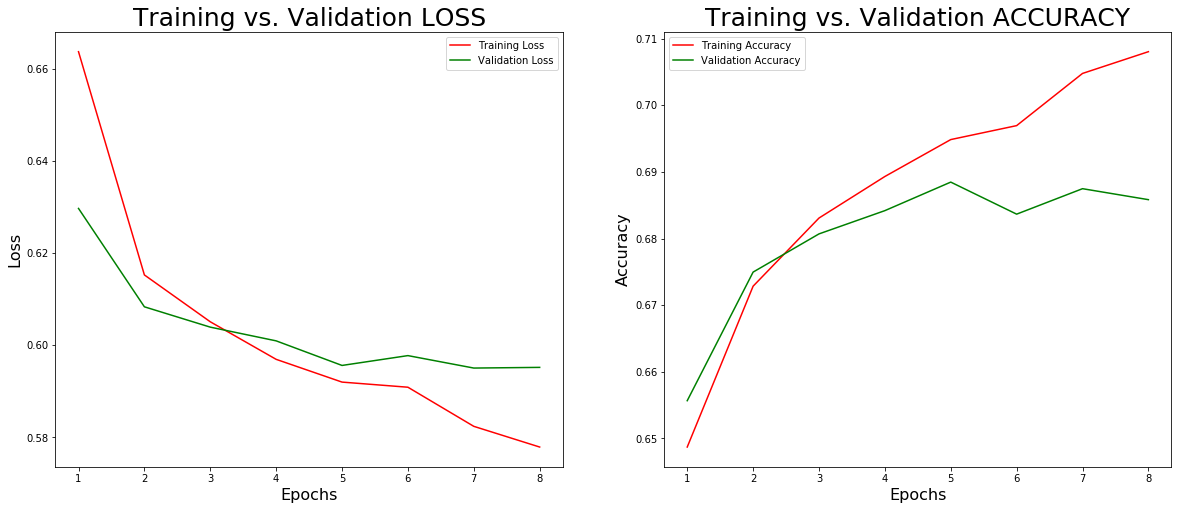

In [94]:
deep_learning_visuals(glove_model1_hist)

# Model 3.1 - Converging on a Final Model

- In pretty much every single model above, the models become overfitted after about 4 epochs. As such for the final model I will only pass the training data through 4 epochs.
- Because GloVe seemed to perform more consistently (less loss over greater epochs), I will use this pre-trained embedding layer in the final model instead of a self-defined embedding layer. 
- Left in 2 dense layers to hopefully improve performance over prior GloVe models

In [103]:
final_model = Sequential()

final_model.add(Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len,
                          output_dim=embedding_matrix.shape[1], 
                          weights=[embedding_matrix], trainable=False))

final_model.add(Bidirectional(GRU(30, return_sequences=True)))
final_model.add(GlobalMaxPool1D())
final_model.add(Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(55, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(2, activation='softmax'))

In [ ]:
#Model compiling
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Model summary
final_model.summary()

In [ ]:
final_model_hist = final_model.fit(X_train, y_train, epochs=4, batch_size=60, validation_split=0.1, verbose=2)

## Final Model Results

In [99]:
results_summary(final_model, "3.1", X_test, y_test)

16874/16874 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7

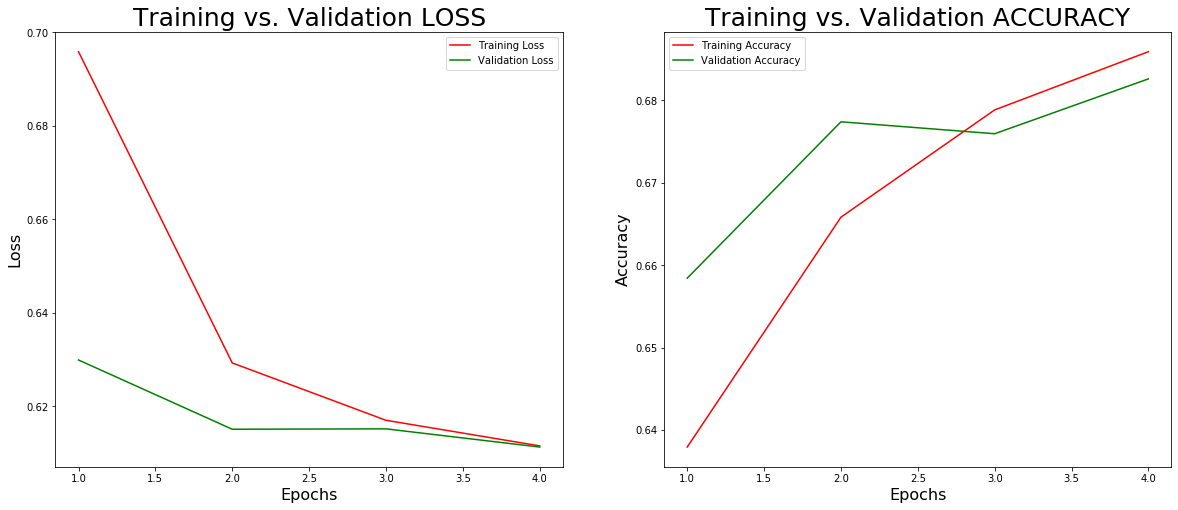

In [101]:
deep_learning_visuals(final_model_hist)

# <font color='red'> INSERT CONFUSION MATRIX FOR FINAL MODEL HERE

# Comparing deep learning results to other machine learning methods

For the sake of comparison, I want to compare the results achieved aboe to standard machine learning models. For this process I will....

- Use TFIDF instead of Keras vectorizer for the models
    - This will provide a nice contrast to the keras models and help me determine if TFIDF is more appropriate
- Try 4 different machine learning models
    - Logistic Regression
    - LinearSVC
    - Random Forest
    - KNearest Neighbors

In [50]:
X = blurb_df['cleaned_text']

In [51]:
# Resetting train and test since we embedded them using Keras above
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.15, random_state=42)

#Using TFIDF vectorizer as discussed above
vectorizer = TfidfVectorizer().fit(X_train2)

#Applying the vectorizer to training/testing data
X_train_tf = vectorizer.transform(X_train2)
X_test_tf = vectorizer.transform(X_test2)

In [52]:
entries_tfidf = []

models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "Multinomial":MultinomialNB(),
    "KNN": KNeighborsClassifier(),
}
for model in models:
    print("training model "+model)
    models[model].fit(X_train_tf, y_train2)

    y_pred = models[model].predict(X_test_tf)
    entries_tfidf.append((model,accuracy_score(y_test2, y_pred)))
    print(classification_report(y_test2, y_pred))

training model LogisticRegression


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.68      0.60      0.64     11078
           1       0.71      0.78      0.75     14233

    accuracy                           0.70     25311
   macro avg       0.70      0.69      0.69     25311
weighted avg       0.70      0.70      0.70     25311

training model RandomForest


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.60      0.63      0.62     11078
           1       0.70      0.68      0.69     14233

    accuracy                           0.66     25311
   macro avg       0.65      0.65      0.65     25311
weighted avg       0.66      0.66      0.66     25311

training model Multinomial
              precision    recall  f1-score   support

           0       0.70      0.49      0.58     11078
           1       0.68      0.84      0.75     14233

    accuracy                           0.69     25311
   macro avg       0.69      0.66      0.66     25311
weighted avg       0.69      0.69      0.68     25311

training model KNN
              precision    recall  f1-score   support

           0       0.44      0.99      0.61     11078
           1       0.85      0.02      0.04     14233

    accuracy                           0.45     25311
   macro avg       0.65      0.51      0.33     25311
weighted avg       0.67     

In [ ]:
entries_tfidf

# NLP Modeling Conclusion

- The best performing model was **INSERT MODEL HERE** with a testing accuracy of  **XXX** and a testing loss of **XXX**
- Surprisingly, traditional machine learning models using TFIDF yielded similar results to the deep learning models despite extensive tuning. 
- Adding regularization to the models helped reduce aggressive loss increase after about 5 epochs. Still the best performing models stopped improving after about 4 epochs. 
- Overall, I'm satisfied with the results of my first deep learning experience, and greatly improved the results through different iterations of the model- more than I could include in this notebook for the sake of my processor. 


# Examing other predictors of Kickstarter Success

Having achieved a pretty high accuracy score for both deep learning models and machine learning models, I wanted to explore other attributes of Kickstarter projects outside of the blurbs. This project is primarily a Natural Language Processing (NLP) project, but for the sake of reccomendations I want to do some quick EDA to determine what attributes make a kickstarter project more likely to be successful. As I began this process there was really 3 questions I wanted to answer.

1. Are certain categories of projects inherently more successful?
2. Do certain countries have higher success rates for their projects?
3. What are the differences between successful and failed projects in regards to goal, backer count, and amount pledged?
4. Are projects picked by staff more likely to succeed?

## 1. Are certain categories of projects inherently more successful?

In [ ]:
df.columns

In [ ]:
# Category is hidden in a long string within the column "category". Below I pull out the category from that string and 
# put it in the category column
f = lambda x: x['category'].split('"slug":"')[1].split('/')[0]
df['category'] = df.apply(f, axis=1)
f = lambda x: x['category'].split('","position"')[0] # Some categories do not have a sub-category, so do not have a '/' to split with
df['category'] = df.apply(f, axis=1)

Through cursory exploration of the data, I determined that a lot of the columns are either not useful or mostly null. As such, Here I will drop any column that I deem unuseful for analyzing successful vs. failed kickstarter projects.

In [ ]:
non_blurb_df = df.drop(['friends', 'is_backing', 'is_starred', 'permissions', 'converted_pledged_amount', 'creator', 
                        'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'fx_rate', 
                        'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'state_changed_at', 'urls', 
                        'usd_type'], axis=1)

In [ ]:
non_blurb_df.columns

In [ ]:
# Quickly building a category df to see total number of successful and failed projects by category
cat_df = pd.get_dummies(non_blurb_df.set_index('category').state).groupby('category').sum()

In [ ]:
cat_df.head()

In [ ]:
# Standardizing goal by applying USD rate to all goals and putting it in a new column
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,15))

# Count of projects
df.groupby('category').category.count().plot(kind='bar', ax=ax1, color='purple')
ax1.set_title('Total Count of Projects by Category')
ax1.set_xlabel('')
ax1.set_ylabel('Count of Projects')

#Median project goal
df.groupby('category').usd_goal.median().plot(kind='bar', ax=ax2)
ax2.set_title('Median project Goal by Category')
ax2.set_xlabel('')
ax2.set_ylabel('Project Goal (USD)')

#Color vector for proportion successful
colors = []
for value in list(cat_df.div(cat_df.sum(axis=1), axis=0)['successful']):
    if value > 0.5:
        colors.append('green')
    else:
        colors.append('red')

#Proportion of successful projects
cat_df.div(cat_df.sum(axis=1), axis=0)['successful'].plot(kind='bar', ax=ax3, color=colors) 
ax3.set_title('Proportion of Successul Projects by Category')
ax3.set_xlabel('')
ax3.axhline(y=0.5, color='red', linestyle='-')
ax3.set_ylabel('Proportion Successful')

fig.subplots_adjust(hspace=0.6)
plt.show()

## Category Conclusions

- Dance and comics have the highest category success rate, but have relatively few projects compared to some other categories.
- Food, journalism, and technology projects have the lowest success rate
    - However, food and technology failures may be driven by the higher median project goal- especially technology

## 2. Do certain countries have higher success rates for their projects?

In [ ]:
# Creating a dataframe grouped by country with columns for failed and successful
country_df = pd.get_dummies(df.set_index('country').state).groupby('country').sum()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,15))

# Count of projects
df.groupby('country').country.count().plot(kind='bar', ax=ax1, color='purple')
ax1.set_title('Total Count of Projects by Country')
ax1.set_xlabel('')
ax1.set_ylabel('Count of Projects')

#Median project goal
df.groupby('country').usd_goal.median().plot(kind='bar', ax=ax2)
ax2.set_title('Median project Goal by Category')
ax2.set_xlabel('')
ax2.set_ylabel('Project Goal (USD)')

#Color vector for proportion successful
colors = []
for value in list(country_df.div(country_df.sum(axis=1), axis=0)['successful']):
    if value > 0.5:
        colors.append('green')
    else:
        colors.append('red')

#Proportion of successful projects
country_df.div(country_df.sum(axis=1), axis=0)['successful'].plot(kind='bar', ax=ax3, color=colors) 
ax3.set_title('Proportion of Successul Projects by Category')
ax3.set_xlabel('')
ax3.axhline(y=0.5, color='red', linestyle='-')
ax3.set_ylabel('Proportion Successful')

fig.subplots_adjust(hspace=0.6)
plt.show()

## Country Conclusions

- An overwhelming majority of projects take place in the USA, therefore this analysis is probably less critical than the category analysis above.
- Projects from Hong Kong and Japan are the two most successful countries, with higher proportion of successful projects and an average sized median project goal.
- Projects in the US are still solid- with just around 60% being successful.

In [ ]:
df.columns

## 3. What are the differences between successful and failed projects in regards to goal, backer count, and amount pledged?

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,20))

df.groupby('state')['state'].count().plot(kind='bar', ax=ax1, color=['#9b001c', '#164f18'])
ax1.set_title('Count of Successful vs. Failed Projects')
ax1.set_xlabel('')
ax1.set_ylabel('Number of Projects')

df.groupby('state')['usd_goal'].median().plot(kind='bar', ax=ax2, color=['#9b001c', '#164f18'])
ax2.set_title('Median USD Goal Success vs. Failed')
ax2.set_xlabel('')
ax2.set_ylabel('Goal(USD)')


df.groupby('state')['usd_pledged'].median().plot(kind='bar', ax=ax3, color=['#9b001c', '#164f18'])
ax3.set_title('Median USD Pledged Success vs. Failed')
ax3.set_xlabel('')
ax3.set_ylabel('Pledged(USD)')

df.groupby('state')['backers_count'].median().plot(kind='bar', ax=ax4, color=['#9b001c', '#164f18'])
ax4.set_title('Median Backers Success vs. Failed')
ax4.set_xlabel('')
ax4.set_ylabel('Backers')

fig.subplots_adjust(hspace=0.2)

## Pledges, Backers, and Goals Conclusions

- Unsuprisingly, the median goal for failed projects was significantly higher than the median goal for successful projects.
    - This indicates that creators of failed projects often set the goal too high and are never able to achieve it.
- Despite on average asking for less money, successful projects have much higher median backers and pledged totals

## Do staff picks have an effect on the success of a project?

In [ ]:
# Creating a dataframe grouped by staff_pick with columns for failed and successful
pick_df = pd.get_dummies(df.set_index('staff_pick').state).groupby('staff_pick').sum()
# Normalizes counts by column, and selects the 'True' category (iloc[1])
#(pick_df.div(pick_df.sum(axis=0), axis=1)).iloc[1].plot(kind='bar', ax=ax9, color=['firebrick', 'seagreen'], rot=0) 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))
pick_df[0:1].groupby('staff_pick').plot(kind='bar', ax=ax1, color=['#9b001c', '#164f18'])
ax1.set_title('Not Staff Pick: Success vs. Failed')
ax1.set_xlabel('')

pick_df[1:2].groupby('staff_pick').plot(kind='bar', ax=ax2, color=['#9b001c', '#164f18'])
ax2.set_title('Staff Pick: Success vs. Failed')
ax2.set_xlabel('')

plt.show()

# Overall Conclusions and Recommendations
- Using words like help, new, album, and book might increase your chances of success in your blurb, but other factors besides the blurb are more important than the exact blub verbage.
    - Recommendation: Make blurbs no more than 20 words and deliver a direct message
- Technology and food projects fail the most often, but also have the highest average ask. 
    - Recommendation: Start a project in a more successful field such as dance or comics
    - Recommendation: If starting a technology or food project, try to establish a lower target
- Projects with higher goals fail far more often.
    - Recommendation: The best goal is under $4000, which is the median successful project goal.
- Projects on average need 70 backers to be successful. Projects that fail have an average of less than 5 backers.
    - Recommendation: Target a slim set of influencers- the quality of a backer is more important than getting 1000s. 
    - MARKETING IS CRUCIAL

# Future Work

- Build a model that incorporates both blurb NLP and the factors mentioned above
- Continue to refine the NLP model with a larger GloVe vocabulary and a bigger/better machine
- Explore how the duration of a project affects its success 
